In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from skimage import io, color, util, exposure
from skimage.segmentation import slic, mark_boundaries
from skimage.exposure import rescale_intensity
from skimage.future import graph
from skimage import transform as trans

In [3]:
import umap

In [68]:
df = pd.read_csv(r'D:\SENYA\ml\data_sets\rag\rag30_new_pics_lab.csv', index_col=(0, 1))
df

L          A          B
Picture Segment                                 
0       1        61.595175   0.023623 -16.704045
        2        75.201458  -0.390732 -20.199692
        3        87.143756  -2.249483   8.603867
        4        46.765673  16.628651  -1.598408
        5        89.718606  -2.302914  30.666758
...                    ...        ...        ...
17      23       13.818013   0.463511   0.165844
        24       52.148160  -2.197026  -6.911158
        25       37.601800  -3.376983 -12.269487
        26       46.590646   1.846271   6.295156
        27        2.984614  -0.117201  -0.505517

[514 rows x 3 columns]

## Применение UMAP

In [77]:
umap_n = 16
umap_dist = 0.025
n_clust = 3
thr = 30

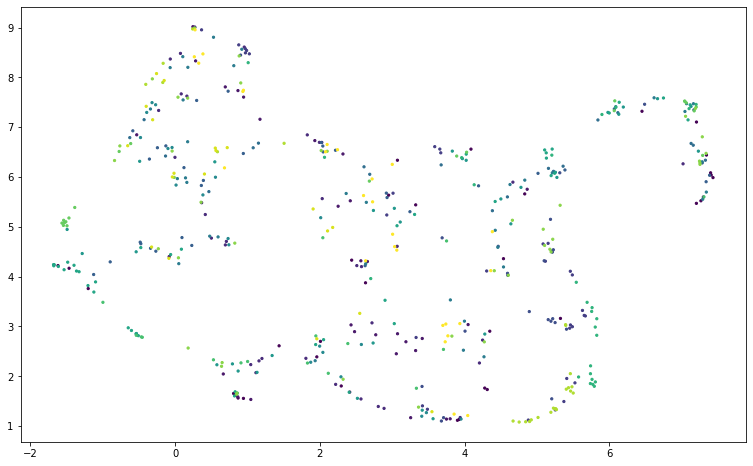

In [70]:
reducer = umap.UMAP(n_neighbors=umap_n, min_dist=umap_dist).fit_transform(df.values)
indexed_reducer = pd.DataFrame(reducer, index=df.index, columns=['x', 'y'])
plt.figure(figsize=(13, 8))
plt.scatter('x', 'y', c=indexed_reducer.index.get_level_values(0), s=5, data=indexed_reducer)

## Иерархическая кластеризация scipy ~ scikit-learn

'shh.'

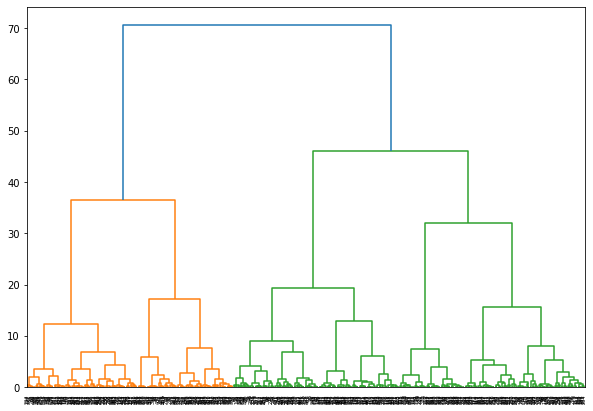

In [72]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
shc.dendrogram(shc.linkage(indexed_reducer.values, method='ward'))
'shh.'

In [78]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=n_clust, affinity='euclidean', linkage='ward')
cluster.fit_predict(indexed_reducer.values).shape
indexed_reducer['cluster'] = cluster.labels_
indexed_reducer.tail(3)

x         y  cluster
Picture Segment                             
17      25       0.682067  6.183191        0
        26       4.382246  4.902553        1
        27       0.275274  8.953197        0

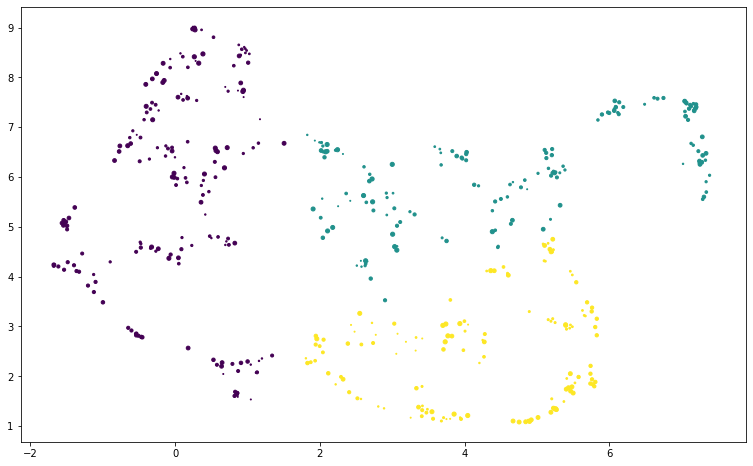

In [79]:
plt.figure(figsize=(13, 8))
plt.scatter('x', 'y', c='cluster', s=indexed_reducer.index.get_level_values(0), data=indexed_reducer)

## Визуализация hclust

In [49]:
# path_to_pics = r'D:\SENYA\ml\data_sets\Oil_from_mat'
path_to_pics = r'D:\SENYA\ml\data_sets\Oil_expanded'
import os
pics_names = os.listdir(path_to_pics)
pics = [path_to_pics + '\\' + i for i in pics_names]

In [17]:
def preproc_img(img, range=2):
    h, w = img.shape[0], img.shape[1]
    k = (1000000 / (w*h)) ** (0.5)
    h, w = h * k, w * k
    img = util.img_as_ubyte(trans.resize(img, (h, w, 3)))
    p_low, p_high = np.percentile(img, (range, 100-range))
    result = exposure.rescale_intensity(img, in_range=(p_low, p_high))
    return result

In [50]:
def merge_segments(img, sliced, thr):
    def _weight_mean_color(graph, src, dst, n):
        diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
        diff = np.linalg.norm(diff)
        return {'weight': diff}
    def merge_mean_color(graph, src, dst):
        graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
        graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
        graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                        graph.nodes[dst]['pixel count'])
                                        
    rag_g = graph.rag_mean_color(img, sliced)
    merged = graph.merge_hierarchical(sliced, rag_g, thresh=thr, rag_copy=False,
                                    in_place_merge=True,
                                    merge_func=merge_mean_color,
                                    weight_func=_weight_mean_color)
    return merged + 1

Text(0.5, 0.98, 'rag20 lab umap_n, umap_dist, n_clust - (16, 0.025, 3)')

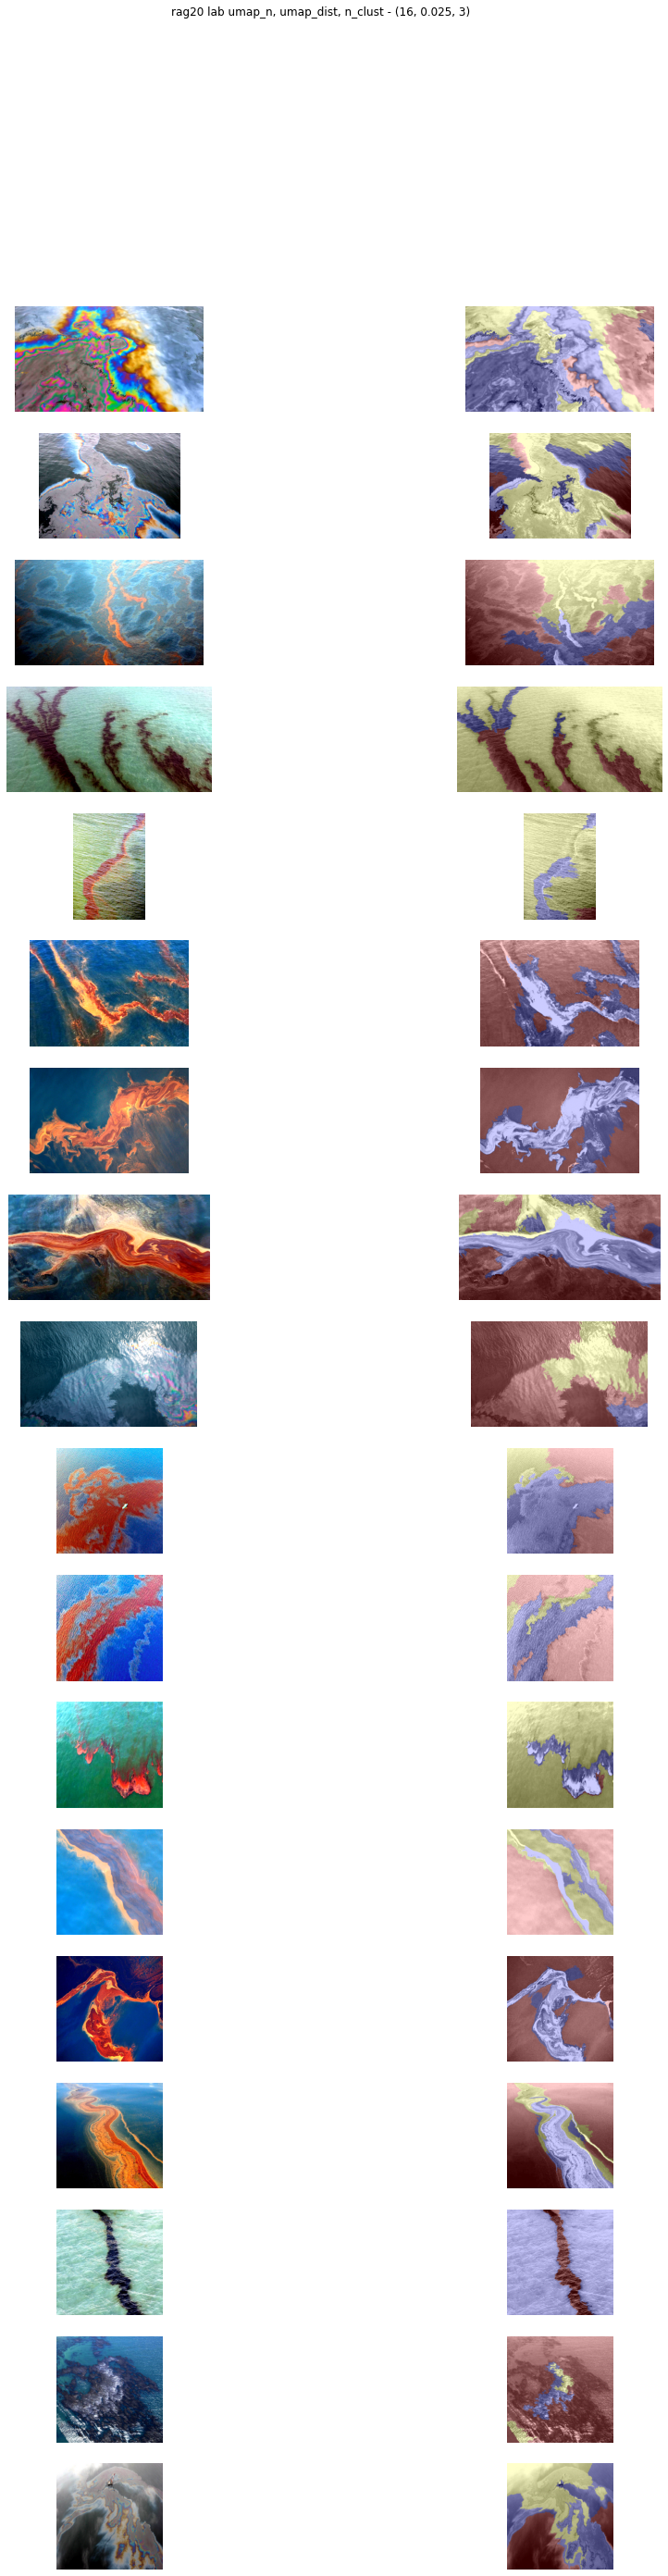

In [80]:
rows = len(pics)
fig, ax = plt.subplots(rows, 2, figsize=(16, rows * 2.5))

for id, path in enumerate(pics):
    img = io.imread(path)
    img = preproc_img(img)
    img_slic = slic(img, 100, sigma=2)
    img_slic = merge_segments(img, img_slic, thr)
    ax[id][0].imshow(img)

    img_meta = indexed_reducer.loc[id]

    labled_img = color.rgb2gray(img)
    for cluster in img_meta.cluster.unique():
        for tone in img_meta[img_meta.cluster == cluster].index:
            mask = img_slic == tone
            np.copyto(labled_img, cluster + 1, where=mask)
    ax[id][1].imshow(color.label2rgb(labled_img, img, alpha=0.2))

    ax[id][1].axis('off')
    ax[id][0].axis('off')
fig.suptitle(f'rag20 lab umap_n, umap_dist, n_clust - {umap_n, umap_dist, n_clust}')